In [1]:
# imports

import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import urllib.request
import ptb_iterator as reader

In [2]:
# load and process data

# file_url = 'https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt'
# file_name = 'tinyshakespeare.txt'

# if not os.path.exists(file_name):
#     urllib.request.urlretrieve(file_url, file_name)
file_name = 'majakovski.txt'

with open(file_name, 'r') as f:
    raw_data = f.read()
    print('Data lenght: {} bytes'.format(len(raw_data)))

vocab = set(raw_data)
vocab_size = len(vocab)
idx_to_vocab = dict(enumerate(vocab))
vocab_to_idx = dict(zip(idx_to_vocab.values(), idx_to_vocab.keys()))

data = [vocab_to_idx[c] for c in raw_data]
del raw_data

Data lenght: 985129 bytes


In [3]:
# utility functions

def gen_epochs(n, num_steps, batch_size):
    for i in range(n):
        yield reader.ptb_iterator(data, batch_size, num_steps)

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

def restore_or_initialize_session(session, saver, checkpoint):
    if isinstance(checkpoint, str):
        try:
            saver.restore(session, checkpoint)
            return
        except:
            print('Failed to restore from checkpoint: {}, initializing variables instead'.format(checkpoint))
    
    session.run(tf.global_variables_initializer())

def train_network(g, num_epochs, num_steps = 200, batch_size = 32, verbose = True, save = False):
    tf.set_random_seed(2345)

    with tf.Session() as sess:
        # try to restore the graph
        restore_or_initialize_session(sess, g['saver'], save)
        training_losses = []
        
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps, batch_size)):
            training_loss = 0
            steps = 0
            training_state = None
            
            for X, Y in epoch:
                # workaround to avoid mis-shaped inputs
                if X.shape[1] != num_steps or Y.shape[1] != num_steps:
                    continue
                steps += 1
                feed_dict = {g['x']: X, g['y']: Y}
                if training_state is not None:
                    feed_dict[g['init_state']] = training_state
                training_loss_, training_state, _ = \
                    sess.run([g['total_loss'], g['final_state'], g['train_step']], feed_dict)
                training_loss += training_loss_

            if verbose:
                print('avg training loss for epoch {0}: {1:.4f}'.format(idx, training_loss/steps))
            
            training_losses.append(training_loss/steps)
        
        # I hate dynamic typing....
        if isinstance(save, str):
            g['saver'].save(sess, save)

    return training_losses

In [4]:
# cell factory
def create_rnn_cells(cell_type, state_size, num_layers):
    state_is_tuple = False
    
    if cell_type == 'GRU':
        cell_creator = lambda: tf.contrib.rnn.GRUCell(state_size)
    elif cell_type == 'LSTM':
        cell_creator = lambda: tf.contrib.rnn.LSTMCell(state_size, state_is_tuple=True)
        state_is_tuple = True
    else:
        cell_creator = lambda: tf.contrib.rnn.BasicRNNCell(cell_size)
        
    cells = [cell_creator() for _ in range(num_layers)]
    return (cells, state_is_tuple)

In [5]:
def build_multilayer_graph(cell_type=None, state_size=100, num_classes=vocab_size, batch_size=32,
        num_steps=200, num_layers=3, learning_rate=1e-4):
    reset_graph()
    
    x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')

    embeddings = tf.get_variable('embedding_matrix', [num_classes, state_size])
    
    # our inputs now is a tensor of dims batch_size x num_steps x state_size
    rnn_inputs = tf.nn.embedding_lookup(embeddings, x)
    
    cells, state_is_tuple = create_rnn_cells(cell_type=cell_type, state_size=state_size, num_layers=num_layers)
    cell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=state_is_tuple)

    init_state = cell.zero_state(batch_size, tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)
    
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, num_classes])
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    
    # reshape rnn outputs and y so we can get the logits in a single matmul
    rnn_outputs = tf.reshape(rnn_outputs, [-1, state_size])
    y_reshaped = tf.reshape(y, [-1])
    
    logits = tf.matmul(rnn_outputs, W) + b
    
    predictions = tf.nn.softmax(logits)
    
    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    
    return dict(x = x, y = y, init_state = init_state, final_state = final_state,
                total_loss = total_loss, train_step = train_step,
                preds = predictions, saver = tf.train.Saver())

In [6]:
# network parameters
cell_type = 'GRU'
num_steps = 60
save_file = 'checkpoints/{0}_{1}s'.format(cell_type, num_steps)

# build the graph
t = time.time()
g = build_multilayer_graph(cell_type=cell_type, num_steps=num_steps)
print('It took {} seconds to build the graph'.format(time.time() - t))

It took 6.103992223739624 seconds to build the graph


In [7]:
# train the network
t = time.time()
losses = train_network(g, num_epochs=3, num_steps=num_steps, save=save_file)
print('It took {} seconds to train the RNN'.format(time.time() - t))

INFO:tensorflow:Restoring parameters from checkpoints/GRU_30s
avg training loss for epoch 0: 3.1871
avg training loss for epoch 1: 2.7152
avg training loss for epoch 2: 2.5579
It took 446.5013871192932 seconds to train the RNN


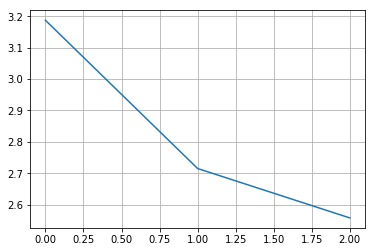

In [8]:
plt.plot(losses)
plt.grid()

## Generating text

In [9]:
def generate_characters(g, checkpoint, num_chars, prompt='A', pick_top_chars=None):
    with tf.Session() as sess:
        g['saver'].restore(sess, checkpoint)
        
        state = None
        current_char = vocab_to_idx[prompt]
        chars = [current_char]
        
        for i in range(num_chars):
            feed_dict = {g['x']: [[current_char]]}

            if state is not None:
                feed_dict[g['init_state']] = state
            
            preds, state = sess.run([g['preds'], g['final_state']], feed_dict)
            
            p = np.squeeze(preds)

            if pick_top_chars is not None:
                p[np.argsort(p)[:-pick_top_chars]] = 0
                p = p / np.sum(p)

            current_char = np.random.choice(vocab_size, 1, p=p)[0]
            
            chars.append(current_char)

    chars = map(lambda x: idx_to_vocab[x], chars)
    return "".join(chars)

In [12]:
g = build_multilayer_graph(cell_type=cell_type, num_steps=1, batch_size=1)
print(generate_characters(g, save_file, 256, prompt='A', pick_top_chars=5))

INFO:tensorflow:Restoring parameters from checkpoints/GRU_30s
Aникаль веньк в белит пуло в вала не подотали.

В станнойстаник.





2.

       о не несенати вельном им воста поринаека полет вырев сонне киску и педоровитонал итом поратотот каренит нилав правовиней половонико савить полилен стоверитьнома нерька в белева
